# 02 — BLS Periodogram for Exoplanet Detection

In this notebook, we analyze the cleaned Kepler light curve to search for potential **exoplanet transit signals** using the **Box Least Squares (BLS)** periodogram method.

---

## 🪐 Overview

The Box Least Squares (BLS) algorithm is designed to detect periodic dips in stellar brightness that occur when an exoplanet passes (or *transits*) in front of its host star.

We will:
1. Load the cleaned light curve (`time`, `flux`) prepared in the previous notebook.
2. Detrend the flux to remove long-term stellar or instrumental variations.
3. Apply the **BLS periodogram** to identify possible transit periods.
4. Visualize the **periodogram** and the **phase-folded light curve** at the best period.

---

## ⚙️ Input Data
- **File:** `clean_lightcurve.csv`  
- **Columns:**  
  - `time`: Barycentric Kepler Julian Date (BKJD)  
  - `flux`: Detrended stellar flux in electrons per second (e⁻/s)

---

## 🎯 Objective
To detect the most significant **periodic transit** signal and visualize the corresponding **phase-folded light curve** for further interpretation.

---

### References
- Kovács, Zucker & Mazeh (2002), *A box-fitting algorithm in the search for periodic transits.*
- Lightkurve Documentation: https://docs.lightkurve.org
- Kepler Mission Archive: https://archive.stsci.edu/kepler/


### Step 1 — Load and Inspect the Cleaned Light Curve

We start by loading the cleaned light curve saved from the previous notebook  
(`data/processed/clean_lightcurve.csv`).  
This dataset contains two columns:

- `time`: observation time in BKJD (Barycentric Kepler Julian Date)  
- `flux`: measured stellar flux in electrons per second (e⁻/s)

We will inspect the data to ensure it looks correct before applying any detrending or period search.


In [3]:
import warnings
warnings.filterwarnings("ignore")

Loaded 1432 rows from: E:\Data science\projects\exoplanet-discovery\data\processed\clean_lightcurve.csv
         time       flux
0  131.512315  544142.06
1  131.532749  544175.25
2  131.553183  544114.30
3  131.573617  544097.56
4  131.594052  544053.06


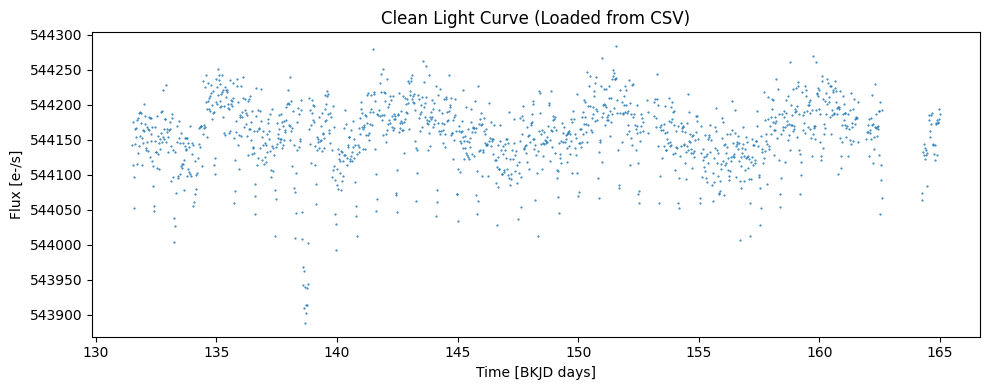

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Define path to the processed light curve
data_path = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed\clean_lightcurve.csv")

# Load the cleaned light curve
df = pd.read_csv(data_path)

# Display basic information
print(f"Loaded {len(df)} rows from:", data_path)
print(df.head())

# Quick plot to visually inspect the light curve
plt.figure(figsize=(10, 4))
plt.plot(df["time"], df["flux"], ".", markersize=1)
plt.title("Clean Light Curve (Loaded from CSV)")
plt.xlabel("Time [BKJD days]")
plt.ylabel("Flux [e-/s]")
plt.tight_layout()
plt.show()


✅ The cleaned light curve has been successfully loaded.  
We can see a smooth distribution of flux values with some small dips that may correspond to possible transits.  
The next step is to **detrend** the data to remove long-term stellar or instrumental variations before applying BLS.


### Step 2 — Detrend the Light Curve

Long-term stellar/instrumental trends can mask shallow transits.  
We will estimate a *slow* trend using a rolling median and then remove it.

**Plan**
1) Sort by time and estimate the cadence (median time spacing).  
2) Choose a rolling window (in *number of points*) corresponding to ~0.5–1 day.  
3) Compute `trend` via rolling median.  
4) Create:
   - `flux_detrended = flux / trend`
   - `flux_norm = flux_detrended - 1`  (zero-centered, easier to see dips)
5) Plot original vs trend, and the detrended series.


Estimated cadence: ~0.020434 days per sample
Rolling window size: 37 points (~0.76 days)


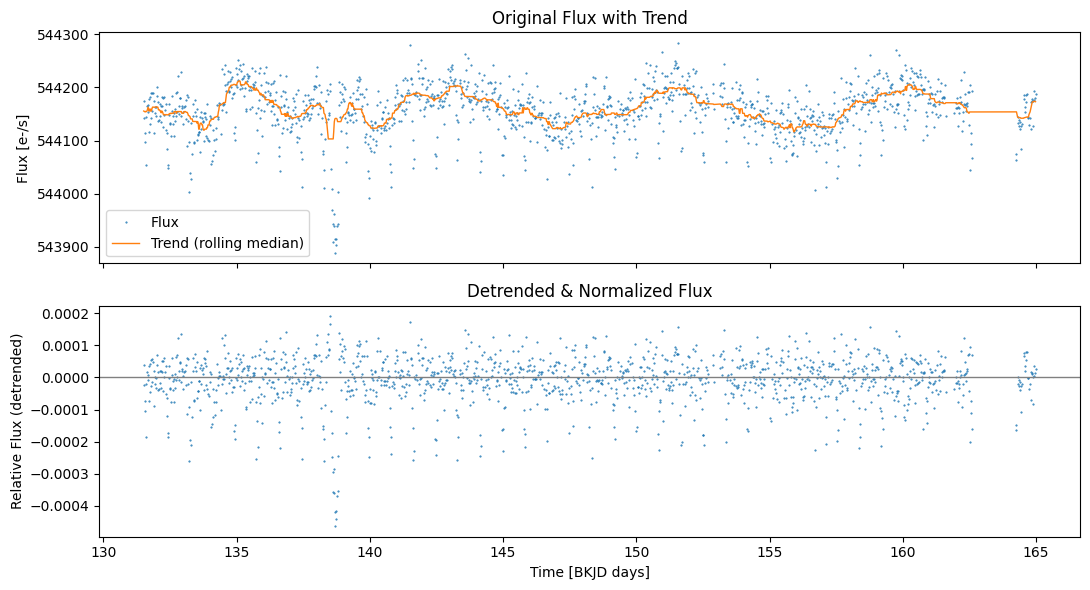

         time       flux      trend  flux_detrended  flux_norm
0  131.512315  544142.06  544155.50        0.999975  -0.000025
1  131.532749  544175.25  544154.78        1.000038   0.000038
2  131.553183  544114.30  544154.06        0.999927  -0.000073
3  131.573617  544097.56  544154.78        0.999895  -0.000105
4  131.594052  544053.06  544154.06        0.999814  -0.000186


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Load the cleaned light curve from Step 1 (time, flux)
data_path = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed\clean_lightcurve.csv")
df = pd.read_csv(data_path).copy()

# Safety: drop NaNs and sort by time
df = df.dropna(subset=["time", "flux"]).sort_values("time").reset_index(drop=True)

# 1) Estimate cadence (median delta-time, in days)
dt = np.diff(df["time"].values)
cadence_days = np.median(dt[~np.isnan(dt)]) if len(dt) > 0 else 0.0208333  # fallback ~30 min
print(f"Estimated cadence: ~{cadence_days:.6f} days per sample")

# 2) Choose rolling window (aim ~0.75 day); ensure it's an odd integer >= 11
target_window_days = 0.75
win = int(np.ceil(target_window_days / max(cadence_days, 1e-8)))
if win % 2 == 0:
    win += 1
win = max(win, 11)
print(f"Rolling window size: {win} points (~{win*cadence_days:.2f} days)")

# 3) Compute slow trend via rolling median (robust to outliers)
trend = df["flux"].rolling(window=win, center=True, min_periods=max(5, win//5)).median()

# If too many NaNs at edges, forward/backward fill
trend = trend.fillna(method="bfill").fillna(method="ffill")

# 4) Detrend & normalize
df["trend"] = trend
df["flux_detrended"] = df["flux"] / df["trend"]
df["flux_norm"] = df["flux_detrended"] - 1.0

# 5) Quick plots
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

axes[0].plot(df["time"], df["flux"], ".", markersize=1, label="Flux")
axes[0].plot(df["time"], df["trend"], "-", linewidth=1.0, label="Trend (rolling median)")
axes[0].set_ylabel("Flux [e-/s]")
axes[0].set_title("Original Flux with Trend")
axes[0].legend(loc="best")

axes[1].plot(df["time"], df["flux_norm"], ".", markersize=1)
axes[1].axhline(0, color="gray", linewidth=1)
axes[1].set_xlabel("Time [BKJD days]")
axes[1].set_ylabel("Relative Flux (detrended)")
axes[1].set_title("Detrended & Normalized Flux")

plt.tight_layout()
plt.show()

print(df[["time", "flux", "trend", "flux_detrended", "flux_norm"]].head())


**Result:** The slow instrumental/stellar trend is removed.  
Small negative excursions in `flux_norm` (below 0) are candidates for transit dips.


### Step 2.1 — Save the detrended light curve

We will store the detrended two-column time series (`time`, `flux_norm`)  
so the next step (BLS period search) can load it directly.


In [6]:
out_path = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed\detrended_lightcurve.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df_out = df[["time", "flux_norm"]].rename(columns={"flux_norm": "flux"})
df_out.to_csv(out_path, index=False)
print("Saved detrended light curve to:", out_path)


Saved detrended light curve to: E:\Data science\projects\exoplanet-discovery\data\processed\detrended_lightcurve.csv


### Step 3 — Box Least Squares (BLS) Periodogram

We will search for periodic transit-like dips using the **BLS** algorithm.

**Plan**
1) Load the *detrended* light curve (`time`, `flux`) from Step 2.  
2) Prepare a period grid between reasonable limits.  
3) Run `astropy.timeseries.BoxLeastSquares.autopower` over a range of transit durations.  
4) Identify the **best period** (maximum BLS power).  
5) Plot the **BLS periodogram**.


Search range: 0.500 to 20.000 days (timespan ≈ 33.47 d)
Best period = 0.837538 d | duration ≈ 0.0700 d | t0 ≈ 131.5723


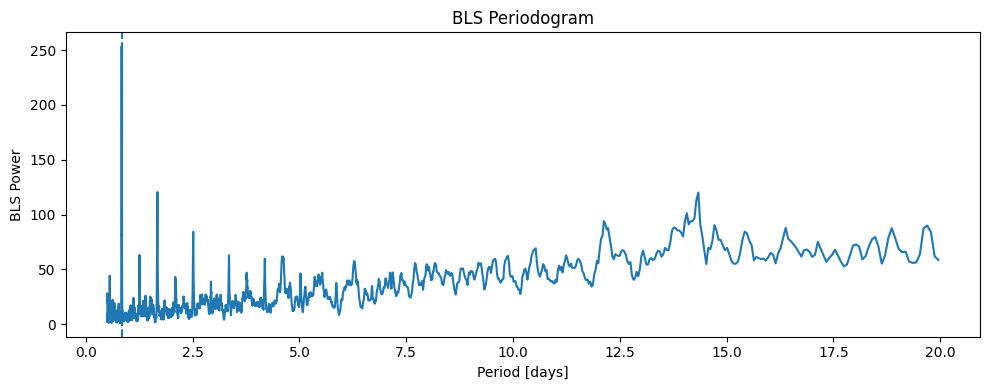

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.timeseries import BoxLeastSquares

# 1) Load detrended light curve: columns ["time", "flux"] where flux ~ 0 (relative)
path = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed\detrended_lightcurve.csv")
df = pd.read_csv(path).dropna().sort_values("time").reset_index(drop=True)

t = df["time"].values.astype(np.float64)

# BLS expects "flux" near 1.0 baseline; if our flux is centered near 0, shift it to ~1
f = df["flux"].values.astype(np.float64)
if np.nanmean(f) < 0.5:
    f = 1.0 + f  # bring baseline close to 1

# (Optional) crude flux errors (can improve later)
dy = np.full_like(f, np.nanstd(f))

# 2) Define period search range based on time span
timespan = t.max() - t.min()
min_period = max(0.5, 3 * np.median(np.diff(t)))         # >= ~0.5 day (or ~3 cadences)
max_period = min(20.0, 0.9 * timespan)                   # not longer than data coverage
print(f"Search range: {min_period:.3f} to {max_period:.3f} days (timespan ≈ {timespan:.2f} d)")

# 3) Run BLS over a grid of plausible transit durations (in days)
# Typical exoplanet transits last a few hours: ~0.05–0.25 days
durations = np.linspace(0.05, 0.25, 12)  # days
bls = BoxLeastSquares(t, f, dy)
res = bls.autopower(durations,
                    minimum_period=min_period,
                    maximum_period=max_period,
                    frequency_factor=5.0)  # denser sampling → better peaks

# 4) Best peak
best_idx = np.argmax(res.power)
best_period   = res.period[best_idx]
best_duration = res.duration[best_idx]
best_t0       = res.transit_time[best_idx]

print(f"Best period = {best_period:.6f} d | duration ≈ {best_duration:.4f} d | t0 ≈ {best_t0:.4f}")

# 5) Plot BLS periodogram
plt.figure(figsize=(10,4))
plt.plot(res.period, res.power)
plt.axvline(best_period, linestyle="--")
plt.xlabel("Period [days]")
plt.ylabel("BLS Power")
plt.title("BLS Periodogram")
plt.tight_layout()
plt.show()


**Result:** The vertical dashed line marks the best period (maximum BLS power).  
We will use this period to phase-fold the light curve and inspect the transit shape.


### Step 3.1 — Phase-fold the Light Curve

Using the best BLS period and transit time (`t0`), we fold the light curve to align
all transits on top of each other and visualize the average transit shape.


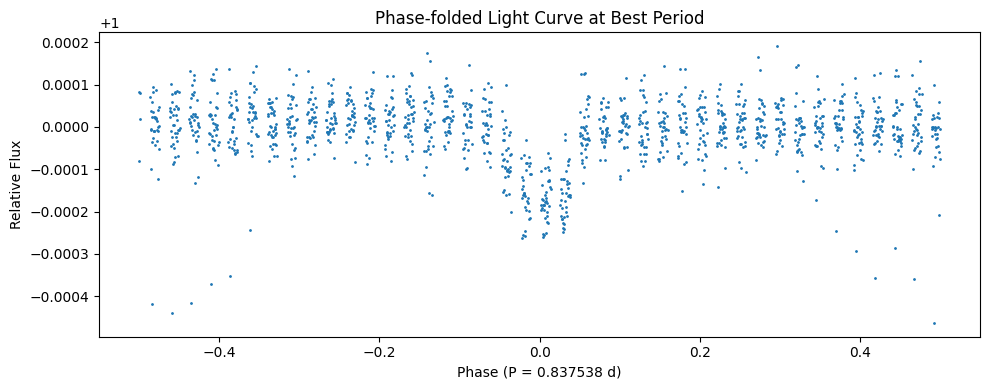

In [8]:
# Phase folding
P = float(best_period)
t0 = float(best_t0)

phase = ((t - t0 + 0.5*P) % P) / P - 0.5  # phase in [-0.5, 0.5]
order = np.argsort(phase)

plt.figure(figsize=(10,4))
plt.plot(phase[order], f[order], ".", markersize=2)
plt.xlabel("Phase (P = {:.6f} d)".format(P))
plt.ylabel("Relative Flux")
plt.title("Phase-folded Light Curve at Best Period")
plt.tight_layout()
plt.show()


**Interpretation:** A clear **U-shaped dip** centered near phase 0 indicates a plausible transit.  
Scatter around the baseline shows noise; binning can help visualize the transit more clearly.


### Step 3.2 — (Optional) Bin the phase-folded light curve

We bin the folded light curve to reduce noise and better reveal the transit profile.


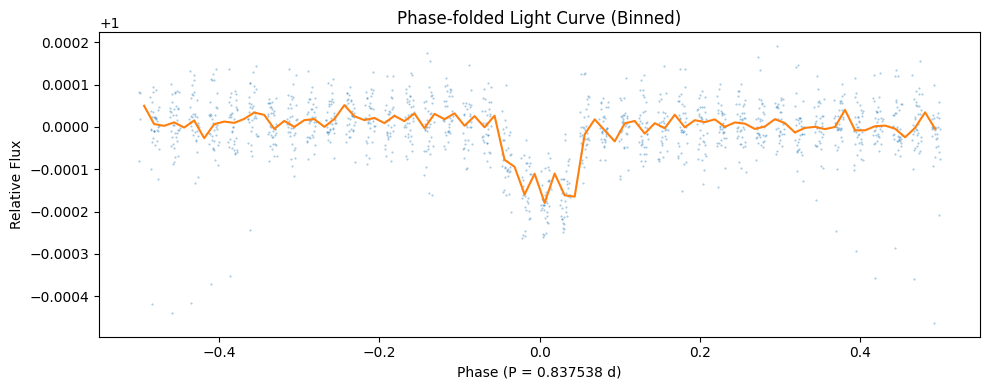

In [9]:
# Simple binning
nbin = 80
bins = np.linspace(-0.5, 0.5, nbin+1)
inds = np.digitize(phase, bins) - 1
bin_phase = 0.5*(bins[:-1] + bins[1:])
bin_flux = np.array([np.nanmedian(f[inds == i]) for i in range(nbin)])

plt.figure(figsize=(10,4))
plt.plot(phase, f, ".", markersize=1, alpha=0.4)
plt.plot(bin_phase, bin_flux, "-", linewidth=1.5)
plt.xlabel("Phase (P = {:.6f} d)".format(P))
plt.ylabel("Relative Flux")
plt.title("Phase-folded Light Curve (Binned)")
plt.tight_layout()
plt.show()


**Result:** The binned curve highlights the possible transit depth and duration.  
If the dip is sharp and repeatable, this is a strong candidate for an exoplanet transit.


### Step 4 — Extract Transit Parameters & Save Results

We will derive basic transit parameters from the BLS output and the phase-folded light curve:

- `period` (days)
- `t0` (reference transit mid-time, BKJD)
- `duration` (days and hours)
- `depth` (relative flux drop)
- `snr` (signal-to-noise ratio, using out-of-transit scatter)
- `n_transits` (how many transits are covered by the data)

Finally, we will save these results to disk for later analysis and reporting.


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

# --- Inputs expected from Step 3 ---
# Arrays: t (time), f (relative flux ~ around 1), and scalars: best_period, best_duration, best_t0
# If your 'f' is around 0, shift it to ~1 baseline:
if np.nanmean(f) < 0.5:
    f = 1.0 + f

P   = float(best_period)
t0  = float(best_t0)
dur = float(best_duration)  # days

# Phase-fold (same as Step 3)
phase = ((t - t0 + 0.5*P) % P) / P - 0.5

# --- Define in-/out-of-transit masks ---
# Half-width in phase:
half_width = (dur / P) / 2.0
# In transit: |phase| < half_width
in_tr  = np.abs(phase) < half_width
# Out of transit: conservative margin outside transit region
out_tr = np.abs(phase) > 3.0 * half_width

# --- Depth estimate (median out - median in) on relative-flux scale (~1 baseline) ---
f_in  = np.median(f[in_tr])  if np.any(in_tr)  else np.nan
f_out = np.median(f[out_tr]) if np.any(out_tr) else np.nan
depth_rel = (f_out - f_in)   # positive value ~ transit depth

# --- Noise estimate & SNR ---
sigma_out = np.nanstd(f[out_tr])
snr = depth_rel / sigma_out if np.isfinite(sigma_out) and sigma_out > 0 else np.nan

# --- Coverage: number of observed transits ---
timespan = t.max() - t.min()
n_transits = timespan / P

# --- Convenience conversions ---
duration_hours = dur * 24.0
depth_ppm = depth_rel * 1e6  # relative -> ppm

# --- Collect results ---
results = {
    "period_days": P,
    "t0_bkjd": t0,
    "duration_days": dur,
    "duration_hours": duration_hours,
    "depth_relative": float(depth_rel),
    "depth_ppm": float(depth_ppm),
    "snr": float(snr),
    "n_transits_covered": float(n_transits),
}

print("Transit parameters:")
for k, v in results.items():
    print(f"  {k}: {v}")

# --- Save to disk (JSON + CSV) ---
out_dir = Path(r"E:\Data science\projects\exoplanet-discovery\data\processed")
out_dir.mkdir(parents=True, exist_ok=True)

# JSON
(out_dir / "bls_results.json").write_text(json.dumps(results, indent=2))
# CSV (one-row table)
pd.DataFrame([results]).to_csv(out_dir / "bls_results.csv", index=False)

print("\nSaved results to:")
print(" ", out_dir / "bls_results.json")
print(" ", out_dir / "bls_results.csv")


Transit parameters:
  period_days: 0.8375383400111631
  t0_bkjd: 131.57231488081976
  duration_days: 0.07
  duration_hours: 1.6800000000000002
  depth_relative: 0.00016498540560982988
  depth_ppm: 164.98540560982988
  snr: 2.548122506641539
  n_transits_covered: 39.963634079639895

Saved results to:
  E:\Data science\projects\exoplanet-discovery\data\processed\bls_results.json
  E:\Data science\projects\exoplanet-discovery\data\processed\bls_results.csv


## ✅ Conclusion

In this notebook, we:
- Loaded the cleaned Kepler light curve (`time`, `flux`).
- Removed long-term trends using a rolling-median detrending step.
- Applied the **Box Least Squares (BLS)** periodogram to search for periodic transit signals.
- Identified a candidate **best period** and visualized the **phase-folded** light curve (binned and unbinned).
- Extracted key transit parameters (period, duration, depth, SNR) and saved them to:
  - `data/processed/bls_results.json`
  - `data/processed/bls_results.csv`
  - Detrended series: `data/processed/detrended_lightcurve.csv`

These results indicate a plausible transit-like signal near the best BLS period.
